## 전이학습(Transfer Learning) 실습 예제

### 환경 설정 및 라이브러리 임포트

In [ ]:
!pip install tqdm
!pip install torchvision
!pip install matplotlib
!pip install torch
!pip install transformers

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
# GPU 사용 가능 여부 확인
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Windows 사용자
device = torch.device('mps') # Mac 사용자
print(f"Using device: {device}")

Using device: mps


### 데이터 다운로드 및 준비

In [18]:
# IMDB 데이터셋 다운로드
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

--2024-07-25 12:30:40--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
ai.stanford.edu (ai.stanford.edu) 해석 중... 171.64.68.10
다음으로 연결 중: ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 84125825 (80M) [application/x-gzip]
저장 위치: `aclImdb_v1.tar.gz'

aclImdb_v1.tar.gz   100%[===================>]  80.23M  7.09MB/s    /  13s     

2024-07-25 12:30:54 (6.03 MB/s) - `aclImdb_v1.tar.gz' 저장함 [84125825/84125825]



In [ ]:
# 데이터 로드 및 전처리
def load_imdb_data(directory):
    data = []
    for sentiment in ['pos', 'neg']:
        path = f'{directory}/{sentiment}'
        for filename in os.listdir(path):
            with open(f'{path}/{filename}', 'r', encoding='utf-8') as file:
                data.append((file.read(), 1 if sentiment == 'pos' else 0))
    return pd.DataFrame(data, columns=['text', 'sentiment'])

In [ ]:
train_data = load_imdb_data('aclImdb/train')
test_data = load_imdb_data('aclImdb/test')

# 훈련 데이터를 훈련셋과 검증셋으로 분할
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")

### 데이터셋 및 DataLoader 정의

In [20]:
class IMDBDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        # 데이터프레임, 토크나이저, 최대 길이를 초기화합니다.
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        # 데이터셋의 총 샘플 수를 반환합니다.
        return len(self.data)
    
    def __getitem__(self, index):
        # 주어진 인덱스의 텍스트와 감성 레이블을 가져옵니다.
        text = self.data.iloc[index]['text']
        sentiment = self.data.iloc[index]['sentiment']
        
        # 텍스트를 토큰화하고 인코딩합니다.
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # 특수 토큰 추가
            max_length=self.max_len,  # 최대 길이 설정
            return_token_type_ids=False,  # 토큰 타입 ID 반환 안 함
            padding='max_length',  # 최대 길이까지 패딩
            truncation=True,  # 최대 길이를 초과하는 경우 자르기
            return_attention_mask=True,  # 어텐션 마스크 반환
            return_tensors='pt',  # PyTorch 텐서로 반환
        )
        
        # 인코딩된 입력, 어텐션 마스크, 감성 레이블을 딕셔너리 형태로 반환합니다.
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'sentiment': torch.tensor(sentiment, dtype=torch.long)
        }


In [21]:
# BERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [22]:
# 데이터셋 생성
max_len = 256
train_dataset = IMDBDataset(train_data, tokenizer, max_len)
val_dataset = IMDBDataset(val_data, tokenizer, max_len)
test_dataset = IMDBDataset(test_data, tokenizer, max_len)

# DataLoader 생성
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


### 모델 준비

In [23]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

### 옵티마이저 정의

In [24]:
optimizer = AdamW(model.parameters(), lr=2e-5)

/Users/dante/aws-ds-class/.conda/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### 학습 루프

In [25]:
# 에폭 수와 손실 저장을 위한 리스트 초기화
num_epochs = 3
train_losses = []
val_losses = []

# 에폭 반복
for epoch in range(num_epochs):
    # 학습 모드로 설정
    model.train()
    total_train_loss = 0
    # 학습 데이터 로더를 통한 배치 처리
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        # 배치 데이터를 디바이스로 이동
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()
        # 모델 순전파
        outputs = model(input_ids, attention_mask=attention_mask, labels=sentiments)
        loss = outputs.loss
        total_train_loss += loss.item()
        
        # 역전파 및 옵티마이저 스텝
        loss.backward()
        optimizer.step()
    
    # 평균 학습 손실 계산 및 저장
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # 평가 모드로 설정
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    # 검증 데이터에 대한 평가
    with torch.no_grad():
        for batch in val_loader:
            # 배치 데이터를 디바이스로 이동
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiments = batch['sentiment'].to(device)

            # 모델 순전파
            outputs = model(input_ids, attention_mask=attention_mask, labels=sentiments)
            loss = outputs.loss
            total_val_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs.logits, 1)
            total += sentiments.size(0)
            correct += (predicted == sentiments).sum().item()
    
    # 평균 검증 손실 및 정확도 계산
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    accuracy = 100 * correct / total
    
    # 에폭 결과 출력
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, '
          f'Val Accuracy: {accuracy:.2f}%')

# 학습 완료 메시지 출력
print("학습 완료!")

Epoch 1/3: 100%|██████████| 1250/1250 [12:46<00:00,  1.63it/s]


Epoch 1/3, Train Loss: 0.2770, Val Loss: 0.2072, Val Accuracy: 91.76%


Epoch 2/3: 100%|██████████| 1250/1250 [13:05<00:00,  1.59it/s]


Epoch 2/3, Train Loss: 0.1446, Val Loss: 0.2307, Val Accuracy: 91.40%


Epoch 3/3: 100%|██████████| 1250/1250 [13:03<00:00,  1.59it/s]


Epoch 3/3, Train Loss: 0.0743, Val Loss: 0.3020, Val Accuracy: 91.04%
학습 완료!


### 결과 시각화

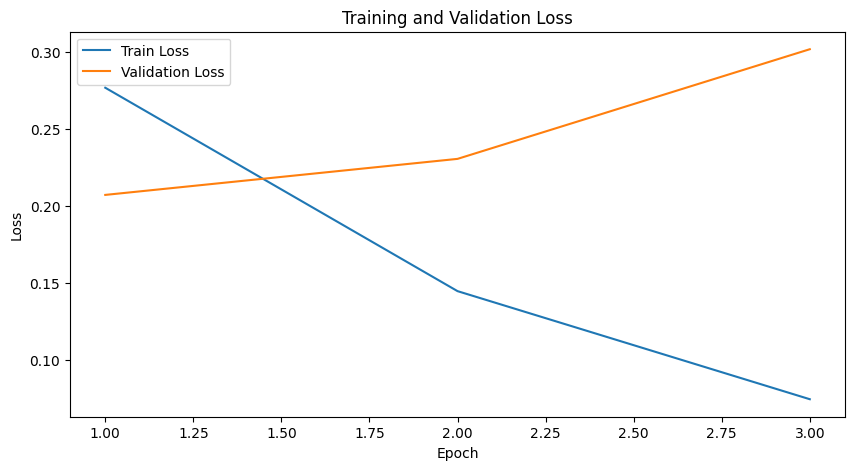

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### 모델 저장

In [27]:
torch.save(model.state_dict(), 'imdb_sentiment_classifier.pth')
print("모델이 저장되었습니다.")

모델이 저장되었습니다.


### 테스트 셋에서 성능 평가

In [28]:
# 모델을 평가 모드로 설정
model.eval()

# 테스트 정확도 계산을 위한 변수 초기화
test_correct = 0
test_total = 0

# 그래디언트 계산 비활성화
with torch.no_grad():
    # 테스트 데이터로더를 순회하며 평가 수행
    for batch in tqdm(test_loader, desc='Testing'):
        # 입력 데이터를 GPU로 이동
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        # 모델 예측 수행
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        
        # 정확도 계산을 위한 데이터 누적
        test_total += sentiments.size(0)
        test_correct += (predicted == sentiments).sum().item()

# 최종 테스트 정확도 계산 및 출력
test_accuracy = 100 * test_correct / test_total
print(f'테스트 정확도: {test_accuracy:.2f}%')

Testing: 100%|██████████| 1563/1563 [05:40<00:00,  4.59it/s]

Test Accuracy: 91.36%
